In [1]:
import os,sys
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
import numpy as np 
from scipy.spatial.distance import pdist
import time 
import math
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

Using TensorFlow backend.


In [2]:
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
%run "OneDrive/Documents/Columbia/Applied Data Science/lib/load.py"

## Loading Data

In [5]:
## change the root to your own path 

#root = sys.path[0]
#train_dir =  os.path.join(root,  '../data/train_set')  
#train_image_dir =  os.path.join(train_dir, 'images')
#train_pt_dir =  os.path.join(train_dir, 'points' )
#train_label_path =  os.path.join(train_dir,  "label.csv")

path = "C:/Users/marko/OneDrive/Documents/Columbia/Applied Data Science/data/train_set/"
data = load.load_data(path+'label.csv')
points_path = "C:/Users/marko/OneDrive/Documents/Columbia/Applied Data Science/data/train_set/points/"
X = load.load_points(points_path,data)
y= data['Index'].to_numpy()

--- 33.069143295288086 seconds ---


## Mat file changes

In [4]:
# read mat file and store coordinates in mat 
m = []
for idx in data['Index']: 
    file = "%04d.mat"%(idx)
    m.append( scipy.io.loadmat( os.path.join( points_path, file )))

mat = [x[[i for i in x.keys() if not i in ['__header__', '__version__', '__globals__']][0]] for x in m]

## Train Test Split

In [6]:
train_x, test_x, train_idx, test_idx = train_test_split(X, y, test_size=0.2, random_state=123)


In [26]:
#train_idx, test_idx = train_test_split(y, test_size=0.2, random_state=123)

In [7]:
train_mat = [ mat[i-1] for i in train_idx ] 
test_mat = [ mat[i-1] for i in test_idx ]

In [8]:
train_labels = data.emotion_idx[train_idx-1]
test_labels = data.emotion_idx[test_idx-1]

In [9]:
train_label_cat = to_categorical(train_labels)
train_label_cat= train_label_cat[:,1:]
test_label_cat = to_categorical(test_labels)
test_label_cat= test_label_cat[:,1:]

In [10]:
train_label_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
test_label_cat

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Feature Extraction

In [12]:
# method 1：  pairwise_dist_cal  
#def pairwise_dist_cal(xy_cord):
    #p_dist =[]
    #for i in range(xy_cord.shape[0]):
        #for j in range(i+1,xy_cord.shape[0]):
               # p_dist.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
               # p_dist.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
    #return p_dist 



#### updated methods with selected fiducial points; this reduce 78 poins to 50  
''' 
feature selection : 1. remove  points P64 - 70 and P72 - 78  
                 2. remove P51,53,55,57,58,60, 61, 63
                 3. calculate midpints between  upper and lower eyebrow lines and replace P20-22,P24-16 with midpoints               
So there is in total 50 points left, which gives 50*49 pairwise distance 
'''

def pairwise_dist_cal_updt(mt):
    t0 = time.time()
    p_dist_updt =np.zeros([len(mt),1225,2])
    n = len(mt)
    for k in range(n):
        xy_cord = mt[k]

        xy_cord_cpy  = xy_cord
        
        #  eye_brow midpoint 
        to_add_brl = (xy_cord_cpy[19:22]+ xy_cord_cpy[23:26])/2
        to_add_brr = (xy_cord_cpy[27:30]+ xy_cord_cpy[31:34])/2

        # index to remove 
        rm_idx = np.append(np.arange(63,70), np.arange(71,78))
        rm_idx = np.append(rm_idx,np.arange(50,57,2) )
        rm_idx = np.append(rm_idx, [57,59,60,62])
        rm_idx = np.append(rm_idx, np.arange(19,22))
        rm_idx = np.append(rm_idx, np.arange(23,26))
        rm_idx = np.append(rm_idx, np.arange(27,30))
        rm_idx = np.append(rm_idx, np.arange(31,34))
        xy_cord = np.delete(xy_cord, rm_idx, axis = 0) 
        xy_cord = np.concatenate((xy_cord,to_add_brl,to_add_brr))
        

        dist_h = [] 
        dist_v = []
        for i in range(xy_cord.shape[0]):
            for j in range(i+1,xy_cord.shape[0]):
                dist_h.append( abs(round(xy_cord[i,0]) - round(xy_cord[j,0] )) )
                dist_v.append( abs(round(xy_cord[i,1]) - round(xy_cord[j,1] ) ) )
        p_dist_updt[k,:,0]= dist_h
        p_dist_updt[k,:,1]= dist_v
    

    print("feature constructions takes %s seconds" % (time.time() - t0))
    return p_dist_updt.reshape([n,2450])

In [13]:
print("training: ")
train_data = pairwise_dist_cal_updt(train_mat[0:])

training: 
feature constructions takes 43.68259143829346 seconds


In [14]:
print("testing: ")
test_data = pairwise_dist_cal_updt(test_mat[0:])

testing: 
feature constructions takes 11.231314182281494 seconds


### LDA

In [15]:
train_labels_lda = [ x  - 1 for x in train_labels ] 
test_labels_lda = [ x  - 1 for x in test_labels ]

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
X_train_lda = lda.fit_transform(train_data, train_labels_lda)

In [17]:
X_test_lda = lda.transform(test_data)

In [18]:
start_time = time.time()

lda_test_pred = lda.predict(test_data)

In [19]:
lda_accuracy = lda.score(test_data, test_labels_lda)
print("Accuracy of the LDA mode: %.4f" % (lda_accuracy))

Accuracy of the LDA mode: 0.3600


### XGB

In [21]:
from xgboost.sklearn import XGBClassifier

In [22]:
train_labels_xgb = [ x  - 1 for x in train_labels ] 
test_labels_xgb = [ x  - 1 for x in test_labels ]

In [23]:
xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators= 200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',  # for multi-labels classification 
 num_class = 22, 
 scale_pos_weight=1,
 seed=123)
start_time=time.time()
xgb.fit(train_data, train_labels_xgb ,eval_metric='auc')
print("training  model takes %s seconds" % round((time.time() - start_time),3))


training  model takes 804.773 seconds


In [24]:
start_time = time.time()
pred_xgb = xgb.predict(test_data)
print("testing model takes %s seconds" % round((time.time() - start_time),3))


testing model takes 0.418 seconds


In [25]:
acc_xgb = accuracy_score(pred_xgb,test_labels_xgb )
print("Test accuracy is %s percent" %(acc_xgb*100))

Test accuracy is 49.6 percent


### XGBoost with CV

In [37]:
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(objective='multi:softprob',seed=36)
parameters = {
   'max_depth': range (1, 5, 1),
   'n_estimators': range(1, 200, 20),
   'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
gscv1 = GridSearchCV(estimator = estimator , 
                        param_grid = parameters, 
                        scoring ='accuracy',
                        cv = 5,
                        n_jobs = -1)
gscv1.fit(train_data, train_labels_xgb)

In [ ]:

# accuracy score
print('Best score for data:', gscv1.best_score_) 

# Find the best parameters for the model by using grid search
print('Best Max Depth:',gscv1.best_estimator_.max_depth) 
print('Best N.estimators:',gscv1.best_estimator_.n_estimators)
print('Best Learning Rate:',gscv1.best_estimator_.learning_rate)

### CNN 

In [26]:
#set predictors
from keras.utils import to_categorical
Y = to_categorical(y)
Y = Y[:,1:]

In [27]:
from sklearn.model_selection import train_test_split
#X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=123)

train_x, test_x, train_idx, test_idx = train_test_split(X, Y, test_size=0.2, random_state=123)


In [35]:
#train_labels_cnn = [ x  - 1 for x in train_labels ] 
#test_labels_cnn = [ x  - 1 for x in test_labels ]

train_labels_cnn = [ x  for x in train_labels ] 
test_labels_cnn = [ x  for x in test_labels ]

In [36]:
train_label_cat = to_categorical(train_labels_cnn)
train_label_cat= train_label_cat[:,1:]
test_label_cat = to_categorical(test_labels_cnn)
test_label_cat= test_label_cat[:,1:]

In [37]:
from keras.layers import Dense, Activation, Flatten, Input,Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization()(input_layer) 
x = Dense(96,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x) 
x = Dense(16,activation='relu',kernel_initializer=initializers.glorot_normal(seed=None))(x)
x = Dropout(0.5)(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=None))(x) 
model = Model(input_layer,output_layer)


In [38]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(train_x, train_label_cat, epochs=200)
print("training  model takes %s seconds" % round((time.time() - start_time),3))


Epoch 1/200
2000/2000 [==============================] - 2s 1ms/step - loss: 3.4590 - accuracy: 0.0590
Epoch 2/200
2000/2000 [==============================] - 1s 699us/step - loss: 3.2104 - accuracy: 0.0765
Epoch 3/200
2000/2000 [==============================] - 1s 703us/step - loss: 3.0991 - accuracy: 0.1000
Epoch 4/200
2000/2000 [==============================] - 1s 708us/step - loss: 3.0061 - accuracy: 0.1065
Epoch 5/200
2000/2000 [==============================] - 1s 714us/step - loss: 2.8994 - accuracy: 0.1290
Epoch 6/200
2000/2000 [==============================] - 1s 729us/step - loss: 2.8402 - accuracy: 0.1410
Epoch 7/200
2000/2000 [==============================] - 2s 759us/step - loss: 2.7576 - accuracy: 0.1470
Epoch 8/200
2000/2000 [==============================] - 2s 824us/step - loss: 2.6887 - accuracy: 0.16700s -
Epoch 9/200
2000/2000 [==============================] - 2s 817us/step - loss: 2.6133 - accuracy: 0.1735
Epoch 10/200
2000/2000 [=============================

Text(0.5, 1.0, 'Accuracy Curves')

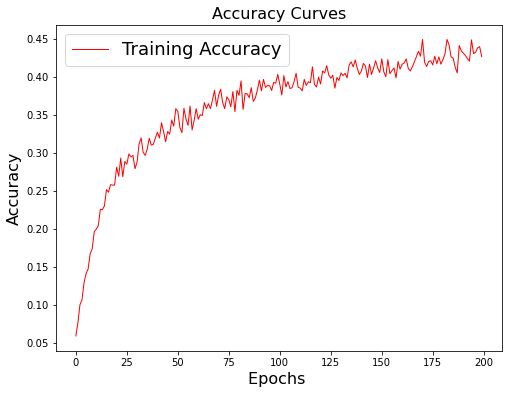

In [43]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [41]:
start = time.time()
pred = model.predict(test_x)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))



Test accuracy is 53.0 percent
testing model takes 0.128 seconds


In [42]:
NN_pred = model.predict(test_x)

### Multiple Iterations test

In [44]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)

In [46]:
from keras.optimizers import Adam
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.01),metrics=['accuracy'])
model.fit(train_x, train_label_cat, validation_data=[test_x, test_label_cat],epochs=50, batch_size=300)
# print('lr=0.01, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_x,train_label_cat,validation_data=[test_x,test_label_cat],epochs=200, batch_size=250)
# print('lr=0.001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.0001),metrics=['accuracy'])
model.fit(train_x, train_label_cat,validation_data=[test_x,test_label_cat],epochs=200, batch_size=200)
# print('lr=0.0001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.00001),metrics=['accuracy'])
model.fit(train_x, train_label_cat, validation_data=[test_x,test_label_cat],epochs=200, batch_size=200)
# print('lr=0.000001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_x,train_label_cat,validation_data=[test_x, test_label_cat],epochs=200, batch_size=250)
# print('lr=0.001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.0001),metrics=['accuracy'])
model.fit(train_x, train_label_cat,validation_data=[test_x, test_label_cat],epochs=200, batch_size=200)
# print('lr=0.0001, train complete')
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.00001),metrics=['accuracy'])
model.fit(train_x, train_label_cat, validation_data=[test_x, test_label_cat],epochs=50, batch_size=200)
# print('lr=0.0001, train complete')
print("--- %s seconds ---" % (time.time() - start_time))

Train on 2000 samples, validate on 500 samples
Epoch 1/50
2000/2000 [==============================] - 1s 637us/step - loss: 3.1294 - accuracy: 0.0620 - val_loss: 17.7691 - val_accuracy: 0.0320
Epoch 2/50
2000/2000 [==============================] - 1s 351us/step - loss: 2.8740 - accuracy: 0.1300 - val_loss: 3.2928 - val_accuracy: 0.1940
Epoch 3/50
2000/2000 [==============================] - 1s 381us/step - loss: 2.4950 - accuracy: 0.2025 - val_loss: 2.7819 - val_accuracy: 0.2180
Epoch 4/50
2000/2000 [==============================] - 1s 358us/step - loss: 2.3102 - accuracy: 0.2455 - val_loss: 2.5626 - val_accuracy: 0.2180
Epoch 5/50
2000/2000 [==============================] - 1s 350us/step - loss: 2.2096 - accuracy: 0.2535 - val_loss: 2.3436 - val_accuracy: 0.2620
Epoch 6/50
2000/2000 [==============================] - 1s 350us/step - loss: 2.0376 - accuracy: 0.3105 - val_loss: 2.3819 - val_accuracy: 0.2700
Epoch 7/50
2000/2000 [==============================] - 1s 335us/step - loss

Text(0.5, 1.0, 'Accuracy Curves')

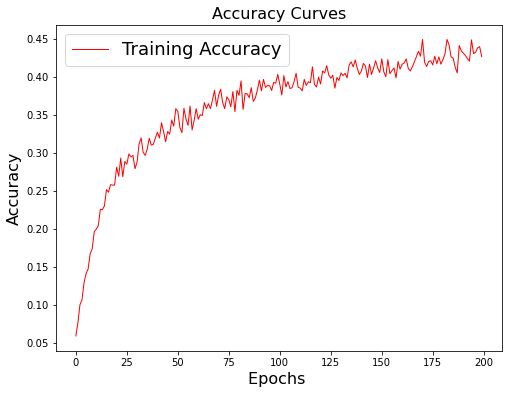

In [47]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [48]:
start = time.time()
pred = model.predict(test_x)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(test_label_cat, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % round((time.time() - start),3))


Test accuracy is 56.2 percent
testing model takes 0.206 seconds
